In [16]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
# IMPORT CÁC THƯ VIỆN CẦN THIẾT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [17]:
#NẠP DỮ LIỆU
# Giả sử file csv là 'Mall_Customers.csv' và có cột 'Annual Income (k$)' và 'Spending Score (1-100)'
df = pd.read_csv('../dataset/Mall_Customers.csv')

In [18]:
# Hiển thị vài hàng để kiểm tra
print("Kích thước dữ liệu:", df.shape)
print(df.head())

Kích thước dữ liệu: (200, 5)
   CustomerID  Gender   Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male  49.0                68.0                    69.0
1           2  Female  56.0                22.0                    47.0
2           3    Male  66.0                41.0                    94.0
3           4    Male  69.0                41.0                    62.0
4           5    Male  49.0               112.0                    69.0


In [19]:
# LỰA CHỌN FEATURE
# Chọn hai cột cần dùng cho phân khúc: Annual Income và Spending Score
# Tùy dataset, tên cột có thể khác. Điều chỉnh tên cột nếu cần.
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].copy()

In [20]:
# TIỀN XỬ LÝ DỮ LIỆU
# Kiểm tra missing
print("Số giá trị thiếu theo cột:\n", X.isnull().sum())

Số giá trị thiếu theo cột:
 Annual Income (k$)        10
Spending Score (1-100)    10
dtype: int64


In [21]:
# Nếu có missing, xử lý (ví dụ: thay bằng median)
for c in X.columns:
    if X[c].isnull().any():
        X[c].fillna(X[c].median(), inplace=True)


C:\Users\luong\AppData\Local\Temp\ipykernel_17952\895810908.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[c].fillna(X[c].median(), inplace=True)


In [22]:
# Scaling: chuẩn hóa để các feature có cùng thang đo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# TÌM SỐ K HỢP LÝ — PHƯƠNG PHÁP ELBOW VÀ SILHOUETTE
# Tính inertia (WSS) cho các k khác nhau và silhouette score để đối chiếu
inertias = []
sil_scores = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    if k > 1:
        sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    else:
        sil_scores.append(np.nan)


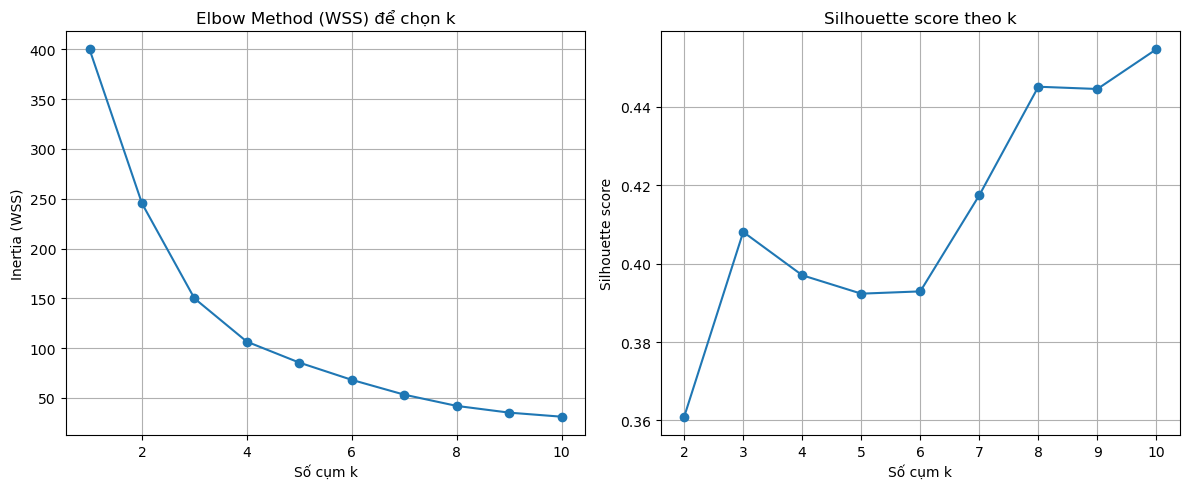

In [24]:
# Vẽ Elbow plot và Silhouette theo k
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method (WSS) để chọn k')
plt.xlabel('Số cụm k')
plt.ylabel('Inertia (WSS)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette score theo k')
plt.xlabel('Số cụm k')
plt.ylabel('Silhouette score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# ÁP DỤNG K-MEANS VỚI k ĐƯỢC CHỌN
# (Giả sử ta chọn k_optimal dựa trên Elbow + Silhouette)
k_optimal = 5  # thay giá trị này bằng giá trị bạn chọn sau khi nhìn đồ thị
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=20)
labels = kmeans_final.fit_predict(X_scaled)

# Gắn nhãn cụm vào DataFrame gốc
df['Cluster'] = labels

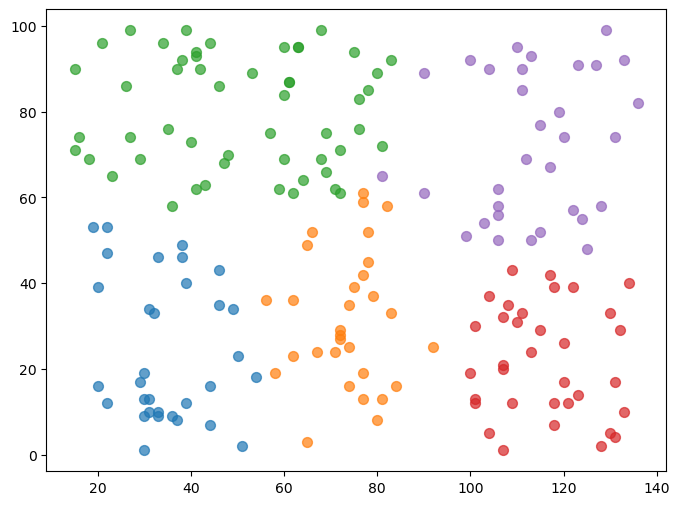

In [26]:
# TRỰC QUAN HÓA KẾT QUẢ (scatter plot theo 2 feature gốc)
# Vẽ scatter dùng giá trị gốc (không scaled) để dễ đọc
plt.figure(figsize=(8,6))
for cl in np.unique(labels):
    mask = df['Cluster'] == cl
    plt.scatter(df.loc[mask, features[0]],
                df.loc[mask, features[1]],
                label=f'Cluster {cl}', s=50, alpha=0.7)


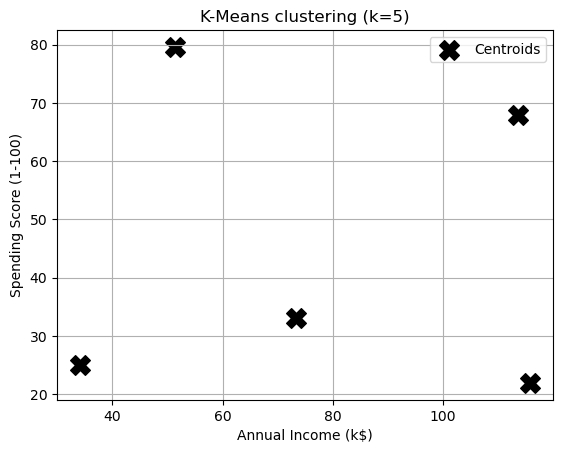

In [27]:
# Vẽ tâm cụm (convert centers back to original scale)
centers_scaled = kmeans_final.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
plt.scatter(centers_orig[:,0], centers_orig[:,1], c='black', s=200, marker='X', label='Centroids')

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title(f'K-Means clustering (k={k_optimal})')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# PHÂN TÍCH NGẮN GỌN KẾT QUẢ
# Thống kê số lượng khách hàng theo cụm và trung bình các feature
summary = df.groupby('Cluster')[features].agg(['count', 'mean', 'median']).round(2)
print("Tóm tắt các cụm:\n", summary)

Tóm tắt các cụm:
         Annual Income (k$)                Spending Score (1-100)              
                     count    mean median                  count   mean median
Cluster                                                                       
0                       33   34.06   33.0                     32  24.25   17.5
1                       32   72.97   74.0                     38  32.21   31.0
2                       52   50.58   50.5                     54  79.61   76.0
3                       34  115.88  116.0                     34  21.91   20.5
4                       39  113.54  113.0                     32  72.09   71.5


In [29]:
# 8. LƯU MÔ HÌNH VÀ SCALER (nếu cần sử dụng lại)
joblib.dump(kmeans_final, '../models/modelskmeans_mall.joblib')
joblib.dump(scaler, '../models/scaler_mall.joblib')
print("Đã lưu mô hình và scaler ra 'kmeans_mall.joblib' và 'scaler_mall.joblib'")

Đã lưu mô hình và scaler ra 'kmeans_mall.joblib' và 'scaler_mall.joblib'
